In [1]:
import numpy as np

In [2]:
    n = 2
    m = 12

    lx = ly = 750000
    x = np.linspace(-lx, lx, n)
    y = np.linspace(-ly, ly, n)
    t = (np.arange(12) + 0.5) / 12

    # assign temperature and precipitation values
    (yy, xx) = np.meshgrid(y, x)
    temp = np.zeros((m, n, n))
    prec = np.zeros((m, n, n))
    stdv = np.zeros((m, n, n))
    for i in range(len(t)):
        temp[i] = -10 * yy / ly - 5 * np.cos(i * 2 * np.pi / 12)
        prec[i] = xx / lx * (np.sign(xx) - np.cos(i * 2 * np.pi / 12))
        stdv[i] = (2 + xx / lx - yy / ly) * (1 - np.cos(i * 2 * np.pi / 12))

    T_obs = temp.reshape(m, -1)
    P_obs = prec.reshape(m, -1)
    S_obs = stdv.reshape(m, -1)

    temp_snow=0.0
    temp_rain=2.0


In [3]:
    def f_inst_pdd(temp, stdv):
        """Compute instantaneous positive degree days from temperature.

        Use near-surface air temperature and standard deviation to compute
        instantaneous positive degree days (effective temperature for melt,
        unit degrees C) using an integral formulation (Calov and Greve, 2005).

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *stdv*: array_like
            Standard deviation of near-surface air temperature in Kelvin.
        """
        import scipy.special as sp

        # compute positive part of temperature everywhere
        positivepart = np.greater(temp, 0) * temp

        # compute Calov and Greve (2005) integrand, ignoring division by zero
        with np.errstate(divide="ignore", invalid="ignore"):
            normtemp = temp / (np.sqrt(2) * stdv)
        calovgreve = stdv / np.sqrt(2 * np.pi) * np.exp(
            -(normtemp**2)
        ) + temp / 2 * sp.erfc(-normtemp)

        # use positive part where sigma is zero and Calov and Greve elsewhere
        teff = np.where(stdv == 0.0, positivepart, calovgreve)

        # convert to degree-days
        return teff * 365.242198781

    def f_accu_rate(temp, prec):
        """Compute accumulation rate from temperature and precipitation.

        The fraction of precipitation that falls as snow decreases linearly
        from one to zero between temperature thresholds defined by the
        `temp_snow` and `temp_rain` attributes.

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Precipitation rate in meter per year.
        """

        # compute snow fraction as a function of temperature
        reduced_temp = (temp_rain - temp) / (temp_rain - temp_snow)
        snowfrac = np.clip(reduced_temp, 0, 1)

        # return accumulation rate
        return snowfrac * prec

    def f_melt_rates(snow, pdd):
        """Compute melt rates from snow precipitation and pdd sum.

        Snow melt is computed from the number of positive degree days (*pdd*)
        and the `pdd_factor_snow` model attribute. If all snow is melted and
        some energy (PDD) remains, ice melt is computed using `pdd_factor_ice`.

        *snow*: array_like
            Snow precipitation rate.
        *pdd*: array_like
            Number of positive degree days.
        """

        # parse model parameters for readability
        ddf_snow = 3 / 1000
        ddf_ice = 8 / 1000

        # compute a potential snow melt
        pot_snow_melt = ddf_snow * pdd

        # effective snow melt can't exceed amount of snow
        snow_melt = np.minimum(snow, pot_snow_melt)

        # ice melt is proportional to excess snow melt
        ice_melt = (pot_snow_melt - snow_melt) * ddf_ice / ddf_snow

        # return melt rates
        return (snow_melt, ice_melt)


In [4]:
        temp = T_obs
        prec = P_obs
        stdv = S_obs
        # compute accumulation and pdd
        accu_rate = f_accu_rate(temp, prec)
        inst_pdd = f_inst_pdd(temp, stdv)

        # initialize snow depth, melt and refreeze rates
        snow_depth = np.zeros_like(temp)
        snow_melt_rate = np.zeros_like(temp)
        ice_melt_rate = np.zeros_like(temp)
        snow_refreeze_rate = np.zeros_like(temp)
        ice_refreeze_rate = np.zeros_like(temp)


In [65]:
cd pdd_estimation/

/Users/andy/base/summer-school-2022/pdd_estimation


-------------------------------------------
Variantional Inference of PDD parameters
-------------------------------------------

Trying to recover:
f_snow=2.6, f_ice=12, f_refreeze=0.25

-------------------------------------------
Setting up SVI
Iteration 0 loss: 2084.917408900847
Recovered parameters
f_snow_loc 2.67
f_snow_scale 1.03
f_ice_loc 6.81
f_ice_scale 1.09
f_refreeze_loc 0.44
f_refreeze_scale 0.10
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2727, in safe_execfile
    py3compat.execfile(
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/utils/py3compat.py", line 55, in execfile
    exec(compiler(f.read(), fname, "exec"), glob, loc)
  File "/Users/andy/base/summer-school-2022/pdd_estimation/MCMC_pyro_inversion.py", line 955, in <module>
    fig.savefig(f"climate_{climate}_snow_{fs}_ice_{fi}_refreeze_{fr}.pdf")
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/figure.py", line 3046, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/backend_bases.py", line 2319, in print_figure
    result = print_method(
  File "/opt/local/Librar

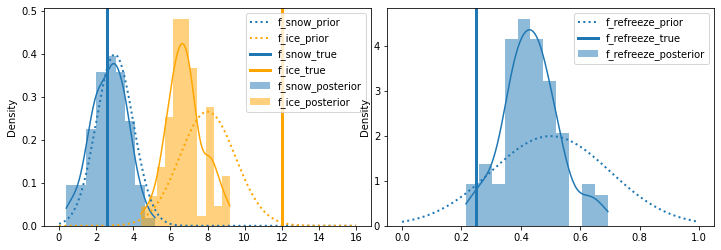

In [79]:
run MCMC_pyro_inversion.py --max_epochs 10

In [70]:
pdd = PDDModel()
r_o = pdd(T_obs, P_obs, std_dev)

In [73]:
r_o["melt"]

array([29.79230484, 23.17179265, 16.20389302, 10.01147597,  5.55481792,
        2.15266727,  0.29830317,  0.        ,  0.        ,  0.        ,
       29.79230484, 23.17179265, 16.28109023, 10.16704274,  5.74280543,
        2.36186148,  0.29830317,  0.        ,  0.        ,  0.        ,
       29.79230484, 23.17179265, 16.35828744, 10.32260951,  5.93079294,
        2.57354325,  0.29830317,  0.        ,  0.        ,  0.        ,
       29.79230484, 23.17179265, 16.43548465, 10.47918016,  6.12060196,
        2.78522503,  0.46260876,  0.        ,  0.        ,  0.        ,
       29.79230484, 23.17179265, 16.51268186, 10.64388899,  6.3155365 ,
        2.9969068 ,  0.68451967,  0.        ,  0.        ,  0.        ,
       29.79230484, 23.17179265, 16.54974025, 10.71643136,  6.38997809,
        3.06029671,  0.70291654,  0.        ,  0.        ,  0.        ,
       29.79230484, 23.17179265, 16.54665981, 10.69680728,  6.34392673,
        2.97539475,  0.5286936 ,  0.        ,  0.        ,  0.  

In [80]:
pdd_t = TorchPDDModel()
r_t = pdd_t(T_obs, P_obs, std_dev)

In [82]:
r_t["melt"].shape

torch.Size([100])

In [83]:
clear